In [7]:
from transformers import AutoModel, AutoTokenizer, AutoImageProcessor
from PIL import Image
import requests
import torch

# Загрузка модели, токенизатора и процессора изображений
model = AutoModel.from_pretrained(
    "visheratin/mexma-siglip",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    optimized=True
).to("cuda")
processor = AutoImageProcessor.from_pretrained("visheratin/mexma-siglip")

# Загрузка и обработка изображения
img_url = "https://static.independent.co.uk/s3fs-public/thumbnails/image/2014/03/25/12/eiffel.jpg"
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png"
img = Image.open(requests.get(img_url, stream=True).raw)
img = processor(images=img, return_tensors="pt")["pixel_values"]
img = img.to(torch.bfloat16).to("cuda")

# Получение эмбеддингов изображения
with torch.inference_mode():
    image_embeddings = model.vision_model(img).last_hidden_state #model.encode_images(img, normalize=False)

# Вывод эмбеддингов
print(image_embeddings.shape)


torch.Size([1, 729, 1152])


In [12]:
tokenizer = AutoTokenizer.from_pretrained("visheratin/mexma-siglip")
max_length = 512
text_inputs = tokenizer(
    ["cat"],
    padding="max_length",
    max_length=max_length,
    truncation=True,
    add_special_tokens=True,
    return_tensors="pt",
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_input_ids = text_inputs.input_ids.to(device)
prompt_attention_mask = text_inputs.attention_mask.to(device)
print(text_input_ids.shape)
print(prompt_attention_mask.shape)
prompt_embeds = model.text_model(input_ids=text_input_ids, attention_mask=prompt_attention_mask)[0]
print(prompt_embeds.shape)

torch.Size([1, 512])
torch.Size([1, 512])
torch.Size([1, 512, 1024])


In [13]:
proj = model.text_projector(prompt_embeds)
print(proj.shape)



torch.Size([1, 512, 1152])


In [ ]:
import torch

# Получаем матрицу весов проектора
weight_matrix = model.text_projector.weight.data  # [1152, 1024]
weight_matrix = weight_matrix.float()  # Преобразуем в float32
#print(weight_matrix)

# Вычисляем псевдообратную матрицу
pseudo_inverse = torch.pinverse(weight_matrix)  # [1024, 1152]
#print(pseudo_inverse)

# Создаем обратный проектор
image_projector = torch.nn.Linear(1152, 1024, bias=False)
image_projector.weight.data = pseudo_inverse
#print(image_projector)

with torch.no_grad():
    image_embeddings_transformed = image_projector(image_embeddings.float())
    print("Shape of image embeddings:", image_embeddings_transformed.shape)

    

Shape of image embeddings: torch.Size([1, 729, 1024])


In [ ]:




import torch
from diffusers import DiffusionPipeline
#from ../models/waifu-2b/pipeline_waifu import WaifuPipeline
generator = torch.Generator(device="cuda").manual_seed(42)

pipe_id = "AiArtLab/waifu-2b"
variant = "fp16"


pipe = DiffusionPipeline.from_pretrained(
    pipe_id, 
    variant=variant,
    trust_remote_code=True,
)
#print(pipe)
pipe.to("cuda")

image = pipe(
    prompt_embeds = image_embeddings_transformed,
    prompt_attention_mask = prompt_attention_mask,
    #negative_prompt = "",
    generator=generator,
)[0]

for img in image:
    img.show()
    #print(prompt)



torch.Size([1, 729])


pipeline_waifu.py:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/3.20G [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

Keyword arguments {'trust_remote_code': True} are not expected by WaifuPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: The expanded size of the tensor (729) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 729].  Tensor sizes: [1, 514]

In [20]:
image_embeddings_transformed = image_embeddings_transformed[:, :512, :] 
prompt_attention_mask = torch.ones(image_embeddings_transformed.shape[0], image_embeddings_transformed.shape[1])
print(prompt_attention_mask.shape)
image_embeddings_transformed = image_embeddings_transformed.to("cuda")
prompt_attention_mask =prompt_attention_mask.to("cuda")

torch.Size([1, 512])


  0%|          | 0/20 [00:00<?, ?it/s]

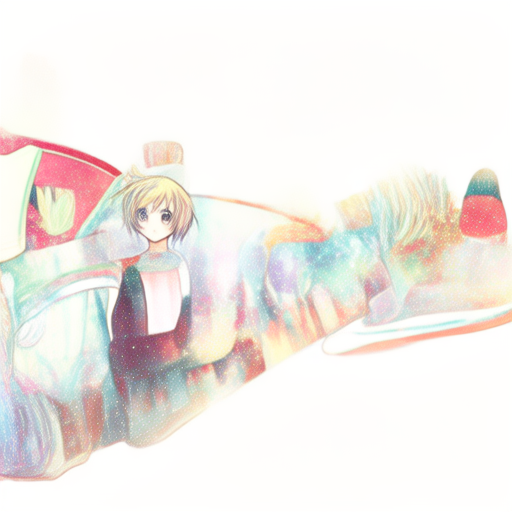

In [21]:
image = pipe(
    prompt_embeds = image_embeddings_transformed,
    prompt_attention_mask = prompt_attention_mask,
    #negative_prompt = "",
    generator=generator,
)[0]

for img in image:
    img.show()